# 🐥 Project 03: 가구 이미지 모델 분류
---
## 주제: 가구 분류 (미세 조정 fine_tuning (유사도 높은 데이터세트 탐색))
---
### 목표 (Target)
- **almirah_dataset (옷장)**
- **chair_dataset (의자)**
- **fridge dataset (냉장고)**
- **table dataset (테이블)**
- **tv dataset (텔레비젼)**


### 목차
1. 데이터셋 불러오기.
2. 데이터 프레임으로 file 경로 및 target 분류.
3. fine_tuning을 통한 학습 시간의 효율적 확보.
4. 데이터 훈련.
5. 데이터 검증.
6. 결론.

## 1. 이미지 불러오기

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

root = './datasets/p_furniture/'

IMAGE_SIZE = 128
BATCH_SIZE = 64

idg = ImageDataGenerator(rescale=1./255)

generator = idg.flow_from_directory(root, target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
print(generator.class_indices)

Found 15000 images belonging to 5 classes.
{'almirah_dataset': 0, 'chair_dataset': 1, 'fridge dataset': 2, 'table dataset': 3, 'tv dataset': 4}


In [2]:
target_name = {v: k for k, v in generator.class_indices.items()}
target_name

{0: 'almirah_dataset',
 1: 'chair_dataset',
 2: 'fridge dataset',
 3: 'table dataset',
 4: 'tv dataset'}

In [3]:
target_names = []
for target in generator.classes:
    target_names.append(target_name[target])

In [4]:
import pandas as pd

f_df = pd.DataFrame({'file_paths': generator.filepaths,'target_names': target_names, 'targets': generator.classes})
f_df

file_paths     target_names  \
0      ./datasets/p_furniture/almirah_dataset/image_1...  almirah_dataset   
1      ./datasets/p_furniture/almirah_dataset/image_1...  almirah_dataset   
2      ./datasets/p_furniture/almirah_dataset/image_1...  almirah_dataset   
3      ./datasets/p_furniture/almirah_dataset/image_1...  almirah_dataset   
4      ./datasets/p_furniture/almirah_dataset/image_1...  almirah_dataset   
...                                                  ...              ...   
14995   ./datasets/p_furniture/tv dataset/image_995.jpeg       tv dataset   
14996   ./datasets/p_furniture/tv dataset/image_996.jpeg       tv dataset   
14997   ./datasets/p_furniture/tv dataset/image_997.jpeg       tv dataset   
14998   ./datasets/p_furniture/tv dataset/image_998.jpeg       tv dataset   
14999   ./datasets/p_furniture/tv dataset/image_999.jpeg       tv dataset   

       targets  
0            0  
1            0  
2            0  
3            0  
4            0  
...        ...  
14995        4  
14996        4  
14997        4  
14998        4  
14999        4  

[15000 rows x 3 columns]

In [5]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_targets, test_targets = \
train_test_split(f_df.file_paths, 
                 f_df.targets, 
                 stratify=f_df.targets, 
                 test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(test_targets.value_counts())

targets
3    2400
0    2400
2    2400
1    2400
4    2400
Name: count, dtype: int64
targets
2    600
4    600
0    600
3    600
1    600
Name: count, dtype: int64


In [6]:
train_images, validation_images, train_targets, validation_targets = \
train_test_split(train_images, train_targets, stratify = train_targets, test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(validation_targets.value_counts())
print(test_targets.value_counts())

targets
2    1920
0    1920
1    1920
3    1920
4    1920
Name: count, dtype: int64
targets
3    480
0    480
1    480
4    480
2    480
Name: count, dtype: int64
targets
2    600
4    600
0    600
3    600
1    600
Name: count, dtype: int64


## 2. 데이터 프레임 분리

In [7]:
train_df = f_df.iloc[train_images.index].reset_index(drop=True)
validation_df = f_df.iloc[validation_images.index].reset_index(drop=True)
test_df = f_df.iloc[test_images.index].reset_index(drop=True)

print(train_df.shape)
print(validation_df.shape)
print(test_df.shape)

(9600, 3)
(2400, 3)
(3000, 3)


## 3-1. 유사도를 확인하기 위해 사전 훈련 모델을 통한 이미지 데이터 확인
- VGG 모델을 사용했을 때 특정 이미지에 대하여 정확한 분류를 진행하였기 때문에 유사도가 높은 것으로 판단.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image 1:
('n04239074', 'sliding_door', 0.9773481)
sliding_door 97.7348%


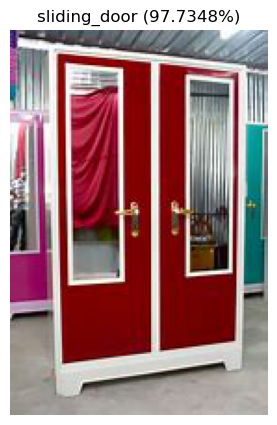



Image 2:
('n04590129', 'window_shade', 0.302527)
window_shade 30.2527%


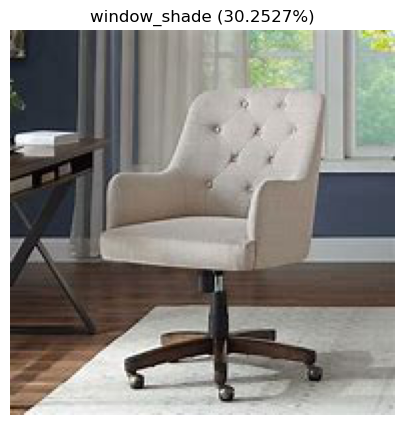



Image 3:
('n04550184', 'wardrobe', 0.6346494)
wardrobe 63.4649%


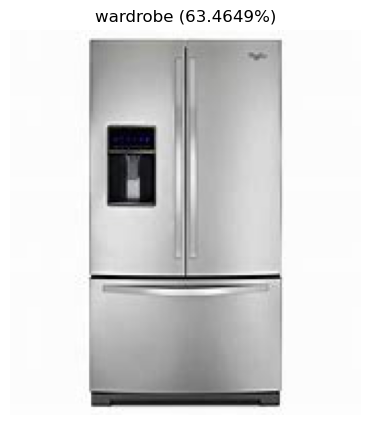



Image 4:
('n03201208', 'dining_table', 0.94068795)
dining_table 94.0688%


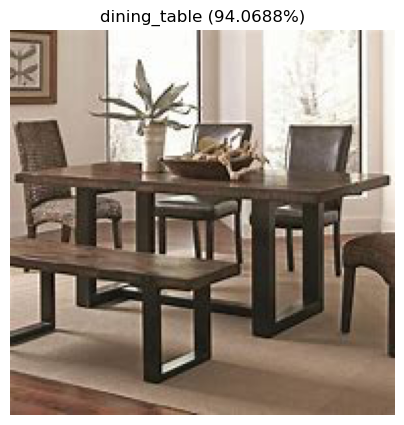



Image 5:
('n04404412', 'television', 0.80063295)
television 80.0633%


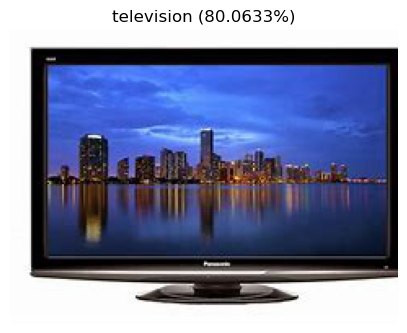

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.vgg16 import VGG16, decode_predictions


# 모델을 로드합니다.
model = VGG16(weights='imagenet')

# 이미지를 로드하고 전처리하는 함수입니다.
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    image = load_img(img_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    return image

# 이미지 출력 함수 선언
def show_image_with_prediction(image, prediction):
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')
    title = f'{prediction[1]} ({np.round(float(prediction[2]) * 100, 4)}%)'
    plt.title(title)
    plt.show()

# 이미지 파일 경로 리스트를 정의합니다.
image_paths = [
    './datasets/p_furniture/almirah_dataset/image_1.jpeg',
    './datasets/p_furniture/chair_dataset/image_1.jpeg',
    './datasets/p_furniture/fridge dataset/image_1.jpeg',
    './datasets/p_furniture/table dataset/image_1.jpeg',
    './datasets/p_furniture/tv dataset/image_1.jpeg'
]

# 이미지를 로드하고 배열로 변환합니다.
images = np.vstack([load_and_preprocess_image(img_path) for img_path in image_paths])

# 예측을 수행합니다.
predictions = model.predict(images)

# 예측 결과를 디코딩하고 출력합니다.
for i, img_path in enumerate(image_paths):
    # 원본 이미지를 로드하고 색상 변환
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    prediction = decode_predictions(np.expand_dims(predictions[i], axis=0))
    
    # 예측 결과 출력 및 이미지 표시
    print(f"Image {i + 1}:")
    print(prediction[0][0])
    print(prediction[0][0][1], f'{np.round(prediction[0][0][2] * 100, 4)}%')
    
    show_image_with_prediction(image, prediction[0][0])
    print("\n")


## 3-2. 일반화를 위한 데이터 증강 및 미세조정 사용
- 초기 훈련 시 속도를 확인 하기 위하여 전체 layer 에 대하여 unfreeze 이후 훈련 진행

In [10]:
import numpy as np
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
import cv2

IMAGE_SIZE = 64
BATCH_SIZE = 64

class Dataset(Sequence):
    def __init__(self, file_paths, targets, batch_size=BATCH_SIZE, aug=None, preprocess=None, shuffle=False):
        self.file_paths = file_paths
        self.targets = targets
        self.batch_size = batch_size
        self.aug = aug
        self.preprocess = preprocess
        self.shuffle = shuffle

        if self.shuffle:
            self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.targets) / self.batch_size))

    # batch_size 단위로 이미지 배열과 타켓 데이터들을 가져온 뒤 변환한 값을 리턴한다.
    def __getitem__(self, index):
        file_paths_batch = self.file_paths[index * self.batch_size: (index + 1) * self.batch_size]
        targets_batch = self.targets[index * self.batch_size: (index + 1) * self.batch_size]

        results_batch = np.zeros((file_paths_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

        for i in range(file_paths_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(file_paths_batch[i]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

            if self.aug is not None:
                image = self.aug(image=image)['image']

            if self.preprocess is not None:
                image = self.preprocess(image)
                    
            results_batch[i] = image

        return results_batch, targets_batch
        
    def on_epoch_end(self):
        if self.shuffle:
            self.file_paths, self.targets = shuffle(self.file_paths, self.targets)        

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': # Inception을 기초로 한 모델
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(5, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [13]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras import layers

IMAGE_SIZE = 64
BATCH_SIZE = 64

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 20
    
    train_file_paths, train_targets, \
    validation_file_paths, validation_targets, \
    test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=preprocess, 
                        shuffle=True)

    validation_dataset = Dataset(validation_file_paths, 
                            validation_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=preprocess)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])

    # feature extractor layer들을 전부 freeze
    for layer in model.layers[:-3]:
        layer.trainable = False

    model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=FIRST_EPOCHS, 
              validation_data=validation_dataset)

    # 배치 정규화만 freeze 진행
    for layer in model.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    # 부분 freeze 진행
    for layer in model.layers:
        layer.trainable = True
    
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=SECOND_EPOCHS, 
              validation_data=validation_dataset)
    
    return model, history

In [14]:
model = create_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        25,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,740,593 (56.23 MB)

 Trainable params: 14,740,593 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# freeze 확인하기
for i, layer in enumerate(model.layers[:-3]):
    # layer.trainable = False
    print(i + 1, '.', layer.name, 'trainable:', layer.trainable)

print('\n######### classifier layers ######### ')
for layer in model.layers[-3:]:
    print(layer.name, 'trainable:', layer.trainable)

1 . input_layer_1 trainable: True
2 . block1_conv1 trainable: True
3 . block1_conv2 trainable: True
4 . block1_pool trainable: True
5 . block2_conv1 trainable: True
6 . block2_conv2 trainable: True
7 . block2_pool trainable: True
8 . block3_conv1 trainable: True
9 . block3_conv2 trainable: True
10 . block3_conv3 trainable: True
11 . block3_pool trainable: True
12 . block4_conv1 trainable: True
13 . block4_conv2 trainable: True
14 . block4_conv3 trainable: True
15 . block4_pool trainable: True
16 . block5_conv1 trainable: True
17 . block5_conv2 trainable: True
18 . block5_conv3 trainable: True
19 . block5_pool trainable: True

######### classifier layers ######### 
global_average_pooling2d trainable: True
dense trainable: True
output trainable: True


## 4-1-1. fine_tuning 을 통한 전체 conv에 대하여 훈련 진행
- VGG16 모델 사용

In [16]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

aug = A.Compose([
    A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.5)
])

model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'vgg16', 
          aug,
          vgg16_preprocess_input)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │        25,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,740,593 (56.23 MB)

 Trainable params: 14,740,593 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 110s 732ms/step - acc: 0.6384 - loss: 4.2178 - val_acc: 0.9542 - val_loss: 0.1723
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 125s 835ms/step - acc: 0.9291 - loss: 0.3208 - val_acc: 0.9908 - val_loss: 0.0271
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 127s 847ms/step - acc: 0.9527 - loss: 0.1830 - val_acc: 1.0000 - val_loss: 0.0063
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 131s 870ms/step - acc: 0.9711 - loss: 0.1143 - val_acc: 1.0000 - val_loss: 0.0043
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 129s 860ms/step - acc: 0.9762 - loss: 0.0754 - val_acc: 0.9987 - val_loss: 0.0068
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 131s 874ms/step - acc: 0.9807 - loss: 0.0744 - val_acc: 1.0000 - val_loss: 0.0022
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 138s 920ms/step - acc: 0.9825 - loss: 0.0623 - val_acc: 1.0000 - val_loss: 0.0013
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 131s 871ms/step - acc: 0.9835 - loss: 0.0654 - val_acc: 1.0000 - val_loss: 0.0010
Epoch 9/10
150/150 ━━━━━━━━━━━━━━━━

In [17]:
import gc
gc.collect()

4025

In [19]:
test_dataset = Dataset(test_file_paths, 
                            test_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=vgg16_preprocess_input)

model.evaluate(test_dataset, batch_size=32)

47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 504ms/step - acc: 0.9903 - loss: 0.0314


[0.02522941678762436, 0.9913333058357239]

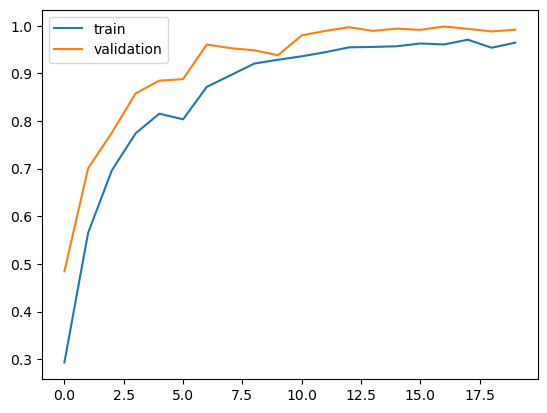

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()

## 4-1-2. 유사도가 높고 전체 분석했을 때도 성능이 높기 떄문에 Conv layer freeze 후 훈련 진행

In [22]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': # Inception을 기초로 한 모델
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(5, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [24]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

IMAGE_SIZE = 64
BATCH_SIZE = 64

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 20
    
    train_file_paths, train_targets, \
    validation_file_paths, validation_targets, \
    test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=preprocess, 
                        shuffle=True)

    validation_dataset = Dataset(validation_file_paths, 
                            validation_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=preprocess)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])


    # 콜백 정의
    mcp_cb = ModelCheckpoint(
        filepath="./callback_files/project03/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
        monitor='val_loss',
        save_best_only=False,
        save_weights_only=True,
        mode='min'
    )

    rlr_cb = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        mode='min',
        verbose=1
    )

    ely_cb = EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min',
        verbose=1
    )

    callbacks = [mcp_cb, rlr_cb, ely_cb]
    
    # feature extractor layer들을 전부 freeze
    for layer in model.layers[:-3]:
        layer.trainable = False

    model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=FIRST_EPOCHS, 
              validation_data=validation_dataset)

    # 배치 정규화만 freeze 진행
    # for layer in model.layers:
    #     if not isinstance(layer, layers.BatchNormalization):
    #         layer.trainable = True

    # 부분 freeze 진행
    # for layer in model.layers[:85]:
    #     layer.trainable = False
    
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=SECOND_EPOCHS, 
              validation_data=validation_dataset,
              callbacks = callbacks)
    
    return model, history

In [ ]:
# # freeze 확인하기
# for i, layer in enumerate(model.layers):
#     layer.trainable = False
#     print(i + 1, '.', layer.name, 'trainable:', layer.trainable)

# print('\n######### classifier layers ######### ')
# for layer in model.layers[-3:]:
#     print(layer.name, 'trainable:', layer.trainable)

In [25]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

aug = A.Compose([
    A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.5)
])

model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'vgg16', 
          aug,
          vgg16_preprocess_input)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │        25,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,740,593 (56.23 MB)

 Trainable params: 14,740,593 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 101s 669ms/step - acc: 0.6605 - loss: 3.2287 - val_acc: 0.9646 - val_loss: 0.1330
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 111s 741ms/step - acc: 0.9290 - loss: 0.2826 - val_acc: 0.9900 - val_loss: 0.0289
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 115s 767ms/step - acc: 0.9516 - loss: 0.1767 - val_acc: 0.9987 - val_loss: 0.0080
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 117s 779ms/step - acc: 0.9687 - loss: 0.0948 - val_acc: 0.9996 - val_loss: 0.0041
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 121s 804ms/step - acc: 0.9738 - loss: 0.0804 - val_acc: 0.9987 - val_loss: 0.0048
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 121s 809ms/step - acc: 0.9791 - loss: 0.0629 - val_acc: 1.0000 - val_loss: 0.0020
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 121s 803ms/step - acc: 0.9853 - loss: 0.0460 - val_acc: 1.0000 - val_loss: 0.0012
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 121s 806ms/step - acc: 0.9865 - loss: 0.0399 - val_acc: 0.9975 - val_loss: 0.0048
Epoch 9/10
150/150 ━━━━━

In [26]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

aug = A.Compose([
    A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.5)
])

model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'vgg16', 
          aug,
          vgg16_preprocess_input)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │        25,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,740,593 (56.23 MB)

 Trainable params: 14,740,593 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 109s 723ms/step - acc: 0.6600 - loss: 3.4311 - val_acc: 0.9696 - val_loss: 0.1032
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 118s 785ms/step - acc: 0.9167 - loss: 0.3036 - val_acc: 0.9975 - val_loss: 0.0141
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 124s 825ms/step - acc: 0.9602 - loss: 0.1449 - val_acc: 0.9975 - val_loss: 0.0097
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 126s 841ms/step - acc: 0.9687 - loss: 0.1140 - val_acc: 1.0000 - val_loss: 0.0041
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 126s 840ms/step - acc: 0.9764 - loss: 0.0759 - val_acc: 1.0000 - val_loss: 0.0036
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 124s 823ms/step - acc: 0.9808 - loss: 0.0667 - val_acc: 1.0000 - val_loss: 0.0023
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 125s 834ms/step - acc: 0.9815 - loss: 0.0527 - val_acc: 1.0000 - val_loss: 0.0019
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 126s 838ms/step - acc: 0.9854 - loss: 0.0539 - val_acc: 1.0000 - val_loss: 0.0014
Epoch 9/10
150/150 ━━━━━

In [27]:
test_dataset = Dataset(test_file_paths, 
                            test_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=vgg16_preprocess_input)

model.evaluate(test_dataset, batch_size=32)

47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 506ms/step - acc: 1.0000 - loss: 2.1253e-05


[1.7810492863645777e-05, 1.0]

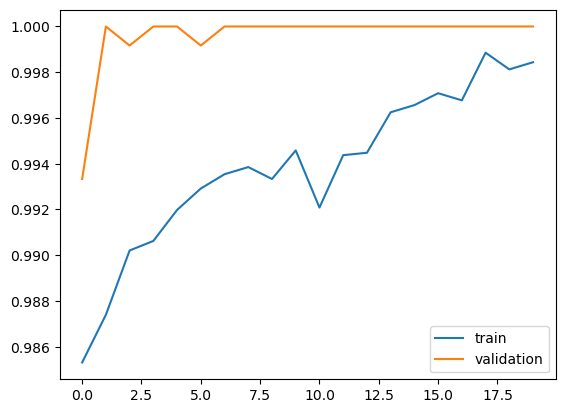

In [28]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()

## VGG 미세조정 후 검증.
- 시간이 약 400s -> 120s로 줄어드는 부분 확인

47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 534ms/step


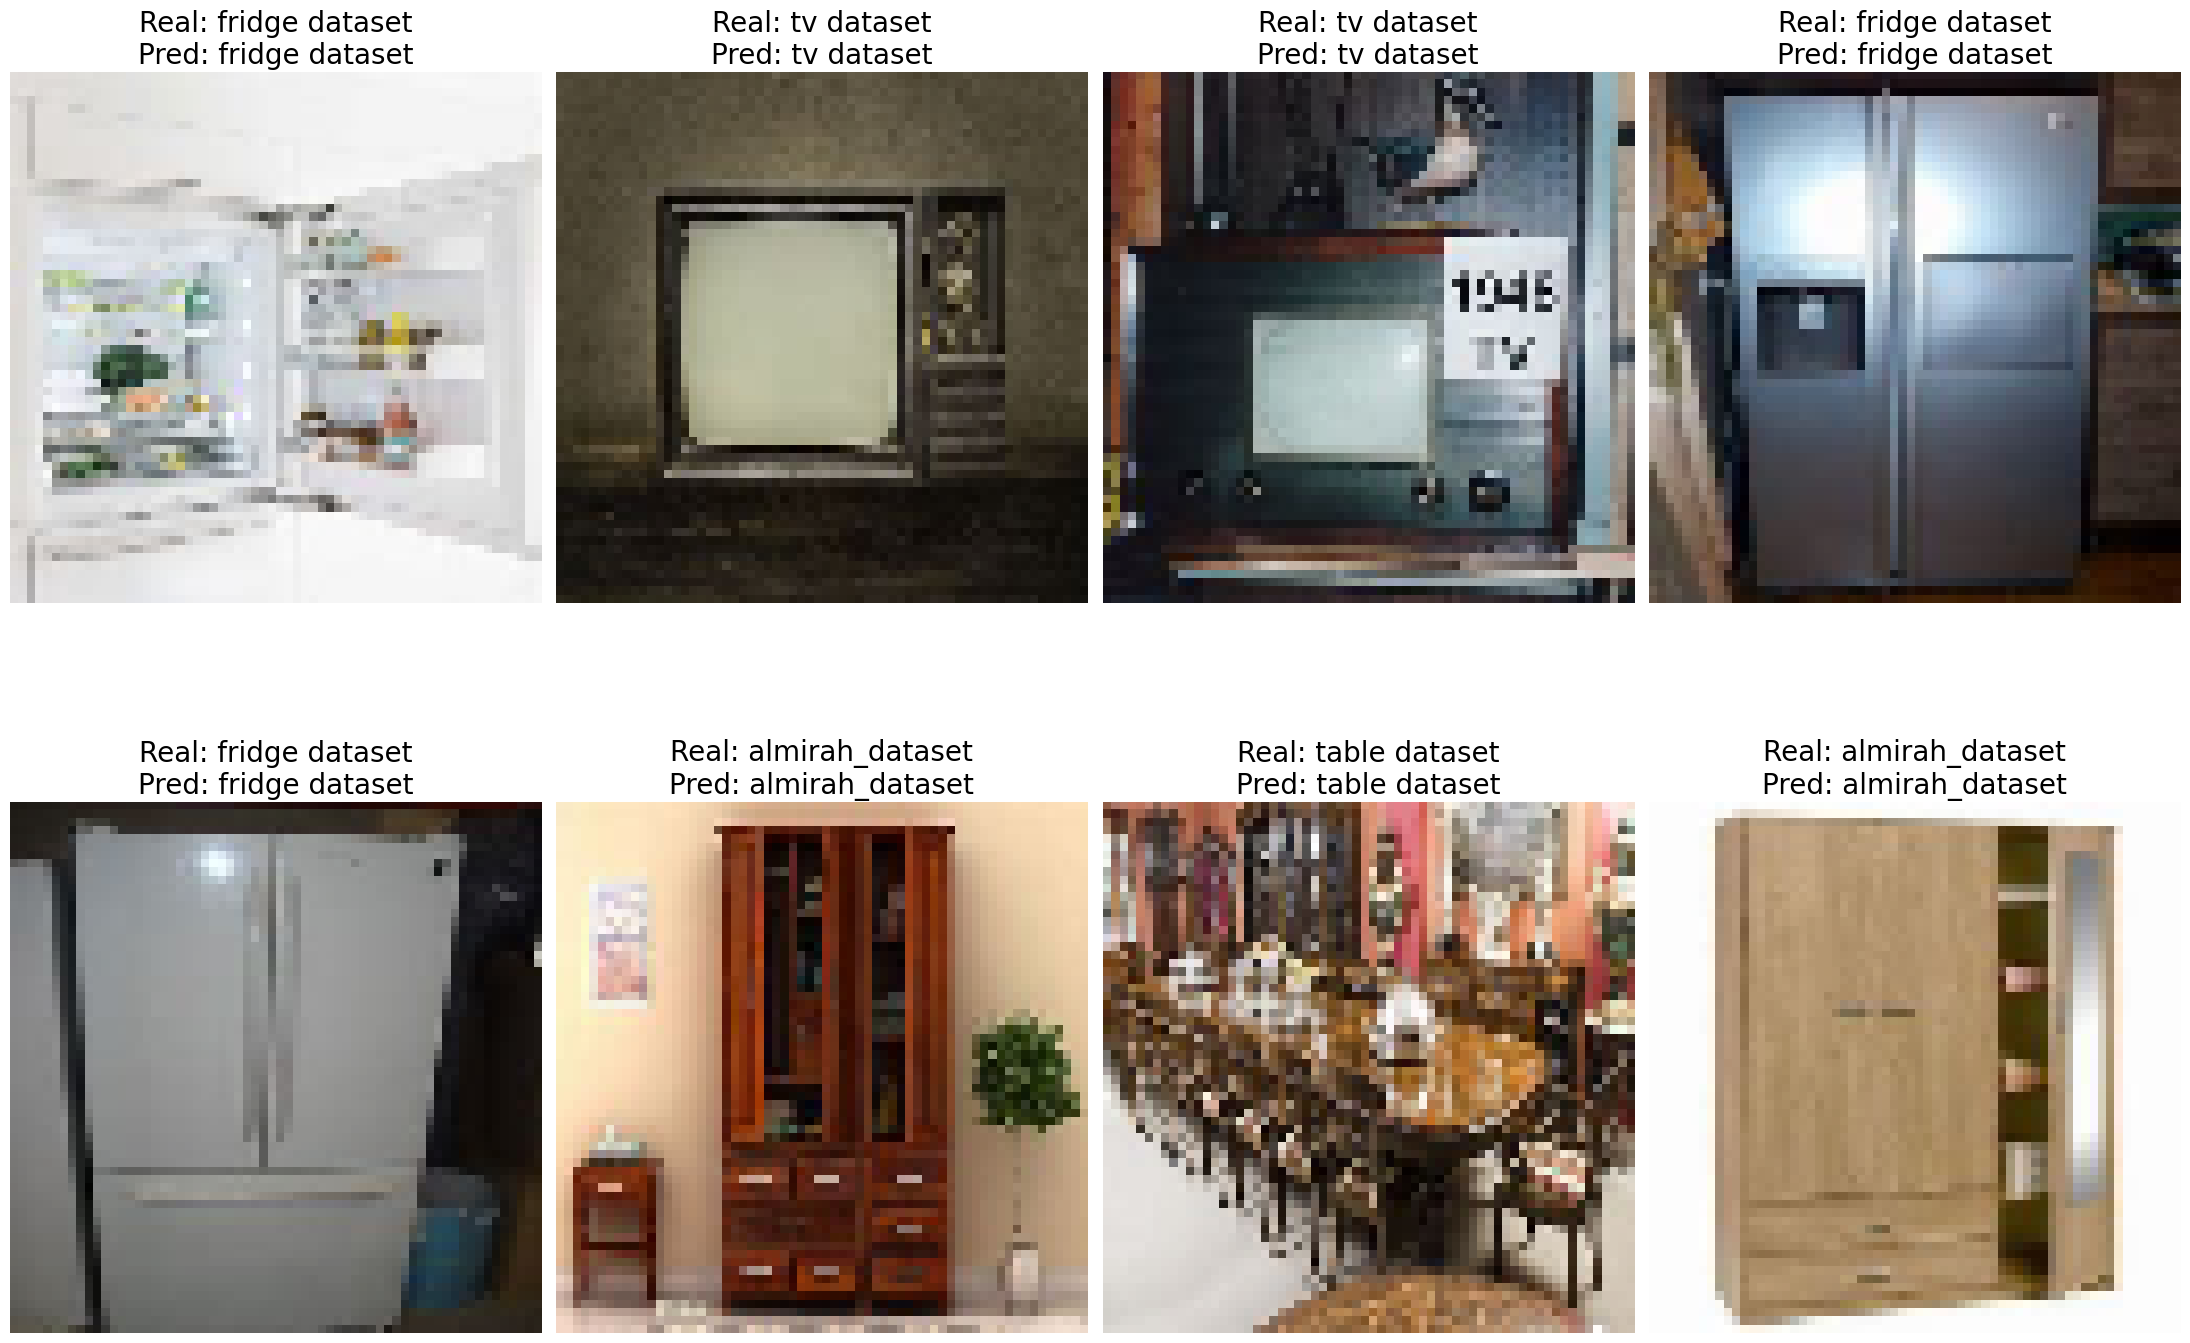

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input

# 클래스 이름 정의
CLASS_NAMES = [
        'almirah_dataset', #0
        'chair_dataset', #1
        'fridge dataset', #2
        'table dataset', #3
        'tv dataset' #4
]

# 이미지 로드 및 전처리 함수
def load_and_preprocess_image(file_path, preprocess=None):
    image = cv2.imread(file_path)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        if preprocess:
            image = preprocess(image)
    else:
        print(f"Error loading image: {file_path}")
        # 오류 발생 시 빈 이미지 또는 대체 이미지 반환
        image = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.uint8)
    return image

# 이미지 크기 설정
IMAGE_SIZE = 64
BATCH_SIZE = 64

# 이미지 시각화 함수 정의
def show_images(images, targets, predictions, nrows=2, ncols=4, fontsize=16):
    fig, axes = plt.subplots(figsize=(22, 16), nrows=nrows, ncols=ncols)
    axes = axes.flatten()  # axes를 1차원 배열로 변환

    for i in range(len(images)):
        ax = axes[i]
        img = images[i]
        ax.imshow(img)
        target = int(targets[i])
        prediction = int(predictions[i])
        ax.set_title(f'Real: {CLASS_NAMES[target]}\nPred: {CLASS_NAMES[prediction]}', fontsize=fontsize)
        ax.axis('off')  # 축 숨기기

    # 사용되지 않는 subplot 숨기기
    for j in range(len(images), nrows * ncols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# 테스트 데이터 제너레이터 생성
test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

test_dataset = Dataset(test_file_paths, 
                        test_targets, 
                        batch_size=BATCH_SIZE,
                        preprocess=vgg16_preprocess_input)

# 모델 예측 수행
pred_probas = model.predict(test_dataset)
pred_classes = np.argmax(pred_probas, axis=1)

# 원본 이미지 로드
real_test_images = np.array([load_and_preprocess_image(fp) for fp in test_file_paths])

# 테스트 데이터와 예측값 시각화 (제너레이터에서 이미지와 타겟을 가져옴)
show_images(real_test_images[:8], test_targets[:8], pred_classes[:8], fontsize=20)


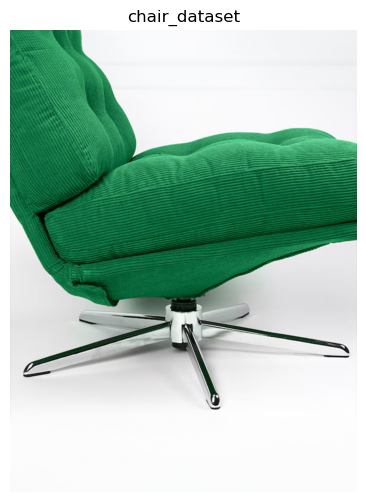

In [31]:
import matplotlib.pyplot as plt
import cv2

root_real_image_project03 = './images/real_project03.webp'

real_image_project03 = cv2.cvtColor(cv2.imread(root_real_image_project03), cv2.COLOR_BGR2RGB)

figure, ax = plt.subplots(figsize=(6, 6), nrows=1, ncols=1)

ax.imshow(real_image_project03)
ax.set_title('chair_dataset')
ax.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


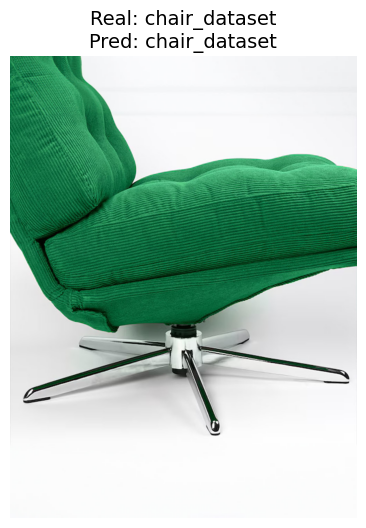

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input

# 클래스 이름 정의
CLASS_NAMES = [
    'almirah_dataset', #0
    'chair_dataset', #1
    'fridge dataset', #2
    'table dataset', #3
    'tv dataset' #4
]

# 이미지 크기 설정
IMAGE_SIZE = 64

# 이미지 로드 및 전처리 함수
def load_and_preprocess_image(file_path, preprocess=None):
    image = cv2.imread(file_path)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        if preprocess:
            image = preprocess(image)
    else:
        print(f"Error loading image: {file_path}")
    return image

# 이미지 시각화 함수 정의
def show_single_image(image, target, prediction, fontsize=16):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f'Real: {CLASS_NAMES[target]}\nPred: {CLASS_NAMES[prediction]}', fontsize=fontsize)
    plt.axis('off')
    plt.show()

# 실제 이미지 경로
root_real_image_project02 = './images/real_project03.webp'
real_image_project02 = load_and_preprocess_image(root_real_image_project02, preprocess=xception_preprocess_input)
origin_image_project02 = cv2.cvtColor(cv2.imread(root_real_image_project02), cv2.COLOR_BGR2RGB)

# 모델 예측 수행
real_image_project02_expanded = np.expand_dims(real_image_project02, axis=0)  # 배치 차원을 추가
pred_probas = model.predict(real_image_project02_expanded)
pred_class = np.argmax(pred_probas, axis=1)[0]

# 실제 이미지 시각화
show_single_image(origin_image_project02, target=1, prediction=pred_class, fontsize=14)


## 4-2-1. VGG 분류기만 훈련했을 때도 점수가 높게 나왔으며 시간적인 효율도 확인하였지만 xception모델에서 어느정도 수치를 보이는지 확인하기 위해 xception 모델 사용

In [33]:
model= create_model(model_name='xception', verbose=True)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 31, 31,    │        864 │ input_layer_5[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 31, 31,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 31, 31,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 29, 29,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 29, 29,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 29, 29,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 29, 29,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 29, 29,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 29, 29,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 29, 29,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 29, 29,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 15, 15,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 15, 15,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 15, 15,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 15, 15,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 15, 15,    │          0 │ add[0][0]       

 Total params: 20,964,185 (79.97 MB)

 Trainable params: 20,909,657 (79.76 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [34]:
model.layers

[<InputLayer name=input_layer_5, built=True>,
 <Conv2D name=block1_conv1, built=True>,
 <BatchNormalization name=block1_conv1_bn, built=True>,
 <Activation name=block1_conv1_act, built=True>,
 <Conv2D name=block1_conv2, built=True>,
 <BatchNormalization name=block1_conv2_bn, built=True>,
 <Activation name=block1_conv2_act, built=True>,
 <SeparableConv2D name=block2_sepconv1, built=True>,
 <BatchNormalization name=block2_sepconv1_bn, built=True>,
 <Activation name=block2_sepconv2_act, built=True>,
 <SeparableConv2D name=block2_sepconv2, built=True>,
 <BatchNormalization name=block2_sepconv2_bn, built=True>,
 <Conv2D name=conv2d, built=True>,
 <MaxPooling2D name=block2_pool, built=True>,
 <BatchNormalization name=batch_normalization, built=True>,
 <Add name=add, built=True>,
 <Activation name=block3_sepconv1_act, built=True>,
 <SeparableConv2D name=block3_sepconv1, built=True>,
 <BatchNormalization name=block3_sepconv1_bn, built=True>,
 <Activation name=block3_sepconv2_act, built=True>,


In [40]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras import layers

IMAGE_SIZE = 64
BATCH_SIZE = 64

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 20
    
    train_file_paths, train_targets, \
    validation_file_paths, validation_targets, \
    test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=preprocess, 
                        shuffle=True)

    validation_dataset = Dataset(validation_file_paths, 
                            validation_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=preprocess)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])

    # feature extractor layer들을 전부 freeze
    for layer in model.layers[:-5]:
        layer.trainable = False

    model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=FIRST_EPOCHS, 
              validation_data=validation_dataset)

    # 배치 정규화만 freeze 진행
    # for layer in model.layers:
    #     if not isinstance(layer, layers.BatchNormalization):
    #         layer.trainable = True

    # 부분 freeze 진행
    # for layer in model.layers[-11:]:
    #     layer.trainable = True
    
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=SECOND_EPOCHS, 
              validation_data=validation_dataset)
    
    return model, history

In [41]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

aug = A.Compose([
    A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.5)
])

model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'xception', 
          aug,
          xception_preprocess_input)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 31, 31,    │        864 │ input_layer_7[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 31, 31,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 31, 31,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 29, 29,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 29, 29,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 29, 29,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 29, 29,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 29, 29,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 29, 29,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 29, 29,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 29, 29,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 15, 15,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 15, 15,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        512 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 15, 15,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 15, 15,    │          0 │ add_24[0][0]    

 Total params: 20,964,185 (79.97 MB)

 Trainable params: 20,909,657 (79.76 MB)

 Non-trainable params: 54,528 (213.00 KB)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 44s 282ms/step - acc: 0.5670 - loss: 1.1277 - val_acc: 0.8687 - val_loss: 0.4268
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 45s 301ms/step - acc: 0.8003 - loss: 0.5933 - val_acc: 0.9317 - val_loss: 0.2721
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 47s 313ms/step - acc: 0.8263 - loss: 0.5050 - val_acc: 0.9483 - val_loss: 0.2092
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 47s 312ms/step - acc: 0.8522 - loss: 0.4372 - val_acc: 0.9613 - val_loss: 0.1790
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 49s 324ms/step - acc: 0.8527 - loss: 0.4190 - val_acc: 0.9554 - val_loss: 0.1611
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 47s 314ms/step - acc: 0.8699 - loss: 0.3872 - val_acc: 0.9725 - val_loss: 0.1241
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 47s 313ms/step - acc: 0.8800 - loss: 0.3550 - val_acc: 0.9746 - val_loss: 0.1095
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 48s 319ms/step - acc: 0.8777 - loss: 0.3461 - val_acc: 0.9775 - val_loss: 0.1119
Epoch 9/10
150/150 ━━━━━━━━━━━━━

In [42]:
test_dataset = Dataset(test_file_paths, 
                            test_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=xception_preprocess_input)

model.evaluate(test_dataset, batch_size=32)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - acc: 0.9978 - loss: 0.0210


[0.02192622795701027, 0.9980000257492065]

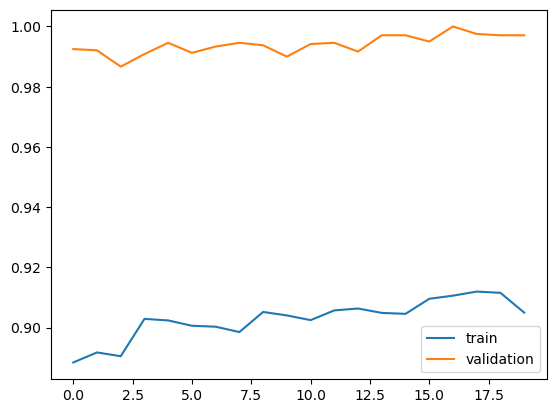

In [43]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()

## 4-1-1(1). image_size=64

47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step


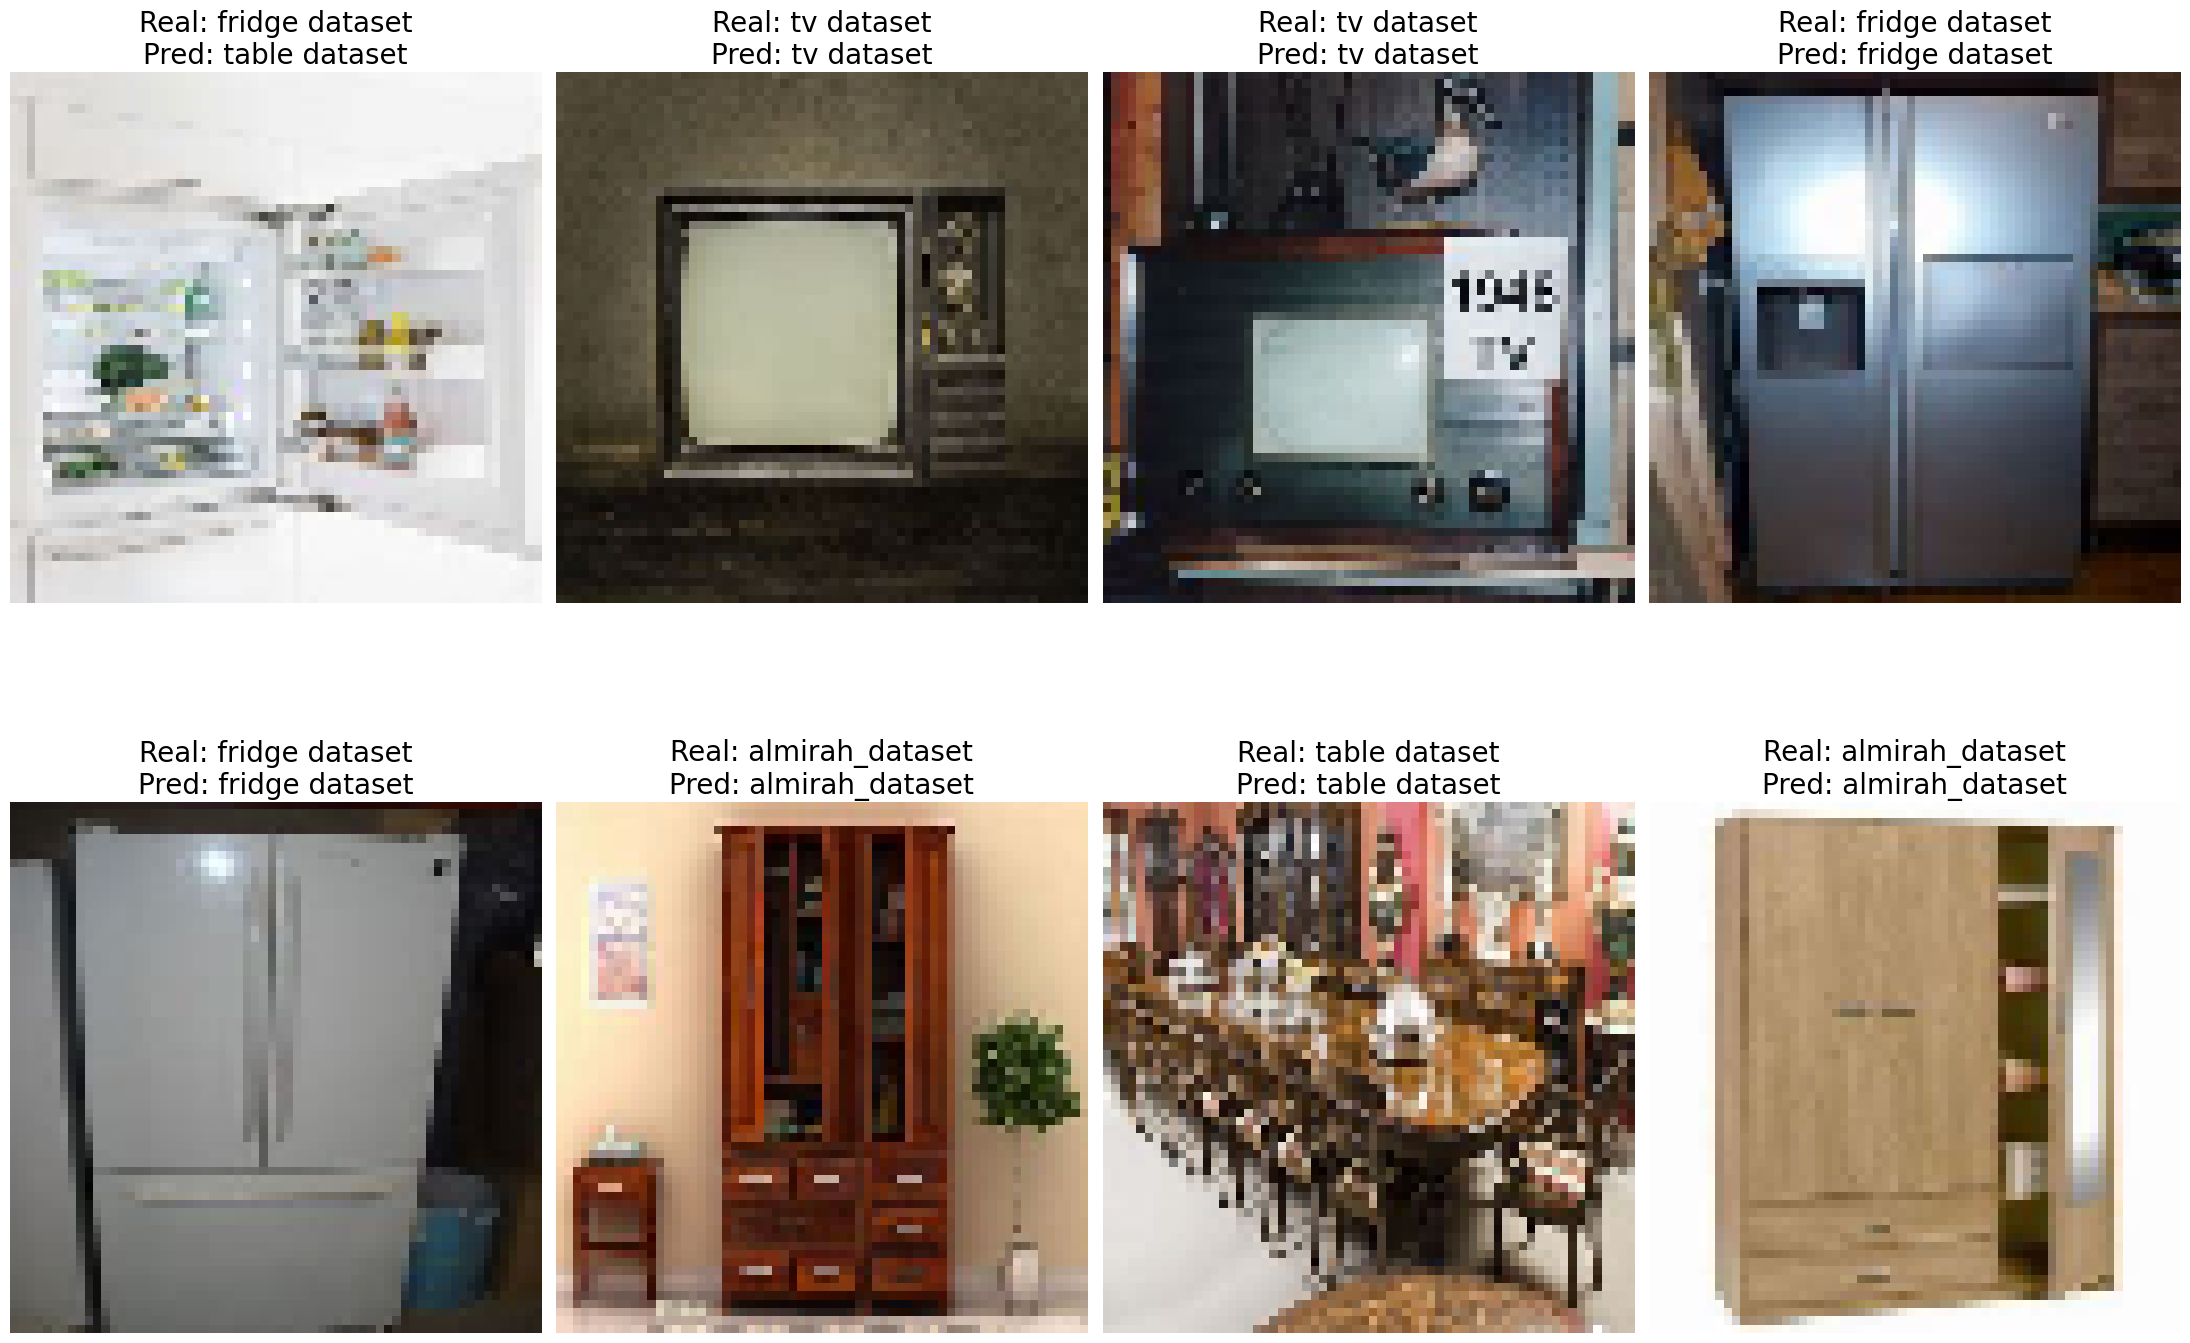

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input

# 클래스 이름 정의
CLASS_NAMES = [
        'almirah_dataset', #0
        'chair_dataset', #1
        'fridge dataset', #2
        'table dataset', #3
        'tv dataset' #4
]

# 이미지 로드 및 전처리 함수
def load_and_preprocess_image(file_path, preprocess=None):
    image = cv2.imread(file_path)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        if preprocess:
            image = preprocess(image)
    else:
        print(f"Error loading image: {file_path}")
        # 오류 발생 시 빈 이미지 또는 대체 이미지 반환
        image = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.uint8)
    return image

# 이미지 크기 설정
IMAGE_SIZE = 64
BATCH_SIZE = 64

# 이미지 시각화 함수 정의
def show_images(images, targets, predictions, nrows=2, ncols=4, fontsize=16):
    fig, axes = plt.subplots(figsize=(22, 16), nrows=nrows, ncols=ncols)
    axes = axes.flatten()  # axes를 1차원 배열로 변환

    for i in range(len(images)):
        ax = axes[i]
        img = images[i]
        ax.imshow(img)
        target = int(targets[i])
        prediction = int(predictions[i])
        ax.set_title(f'Real: {CLASS_NAMES[target]}\nPred: {CLASS_NAMES[prediction]}', fontsize=fontsize)
        ax.axis('off')  # 축 숨기기

    # 사용되지 않는 subplot 숨기기
    for j in range(len(images), nrows * ncols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# 테스트 데이터 제너레이터 생성
test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

test_dataset = Dataset(test_file_paths, 
                        test_targets, 
                        batch_size=BATCH_SIZE,
                        preprocess=xception_preprocess_input)

# 모델 예측 수행
pred_probas = model.predict(test_dataset)
pred_classes = np.argmax(pred_probas, axis=1)

# 원본 이미지 로드
real_test_images = np.array([load_and_preprocess_image(fp) for fp in test_file_paths])

# 테스트 데이터와 예측값 시각화 (제너레이터에서 이미지와 타겟을 가져옴)
show_images(real_test_images[:8], test_targets[:8], pred_classes[:8], fontsize=20)


## 4-1-1(2). image_size=299

47/47 ━━━━━━━━━━━━━━━━━━━━ 236s 5s/step


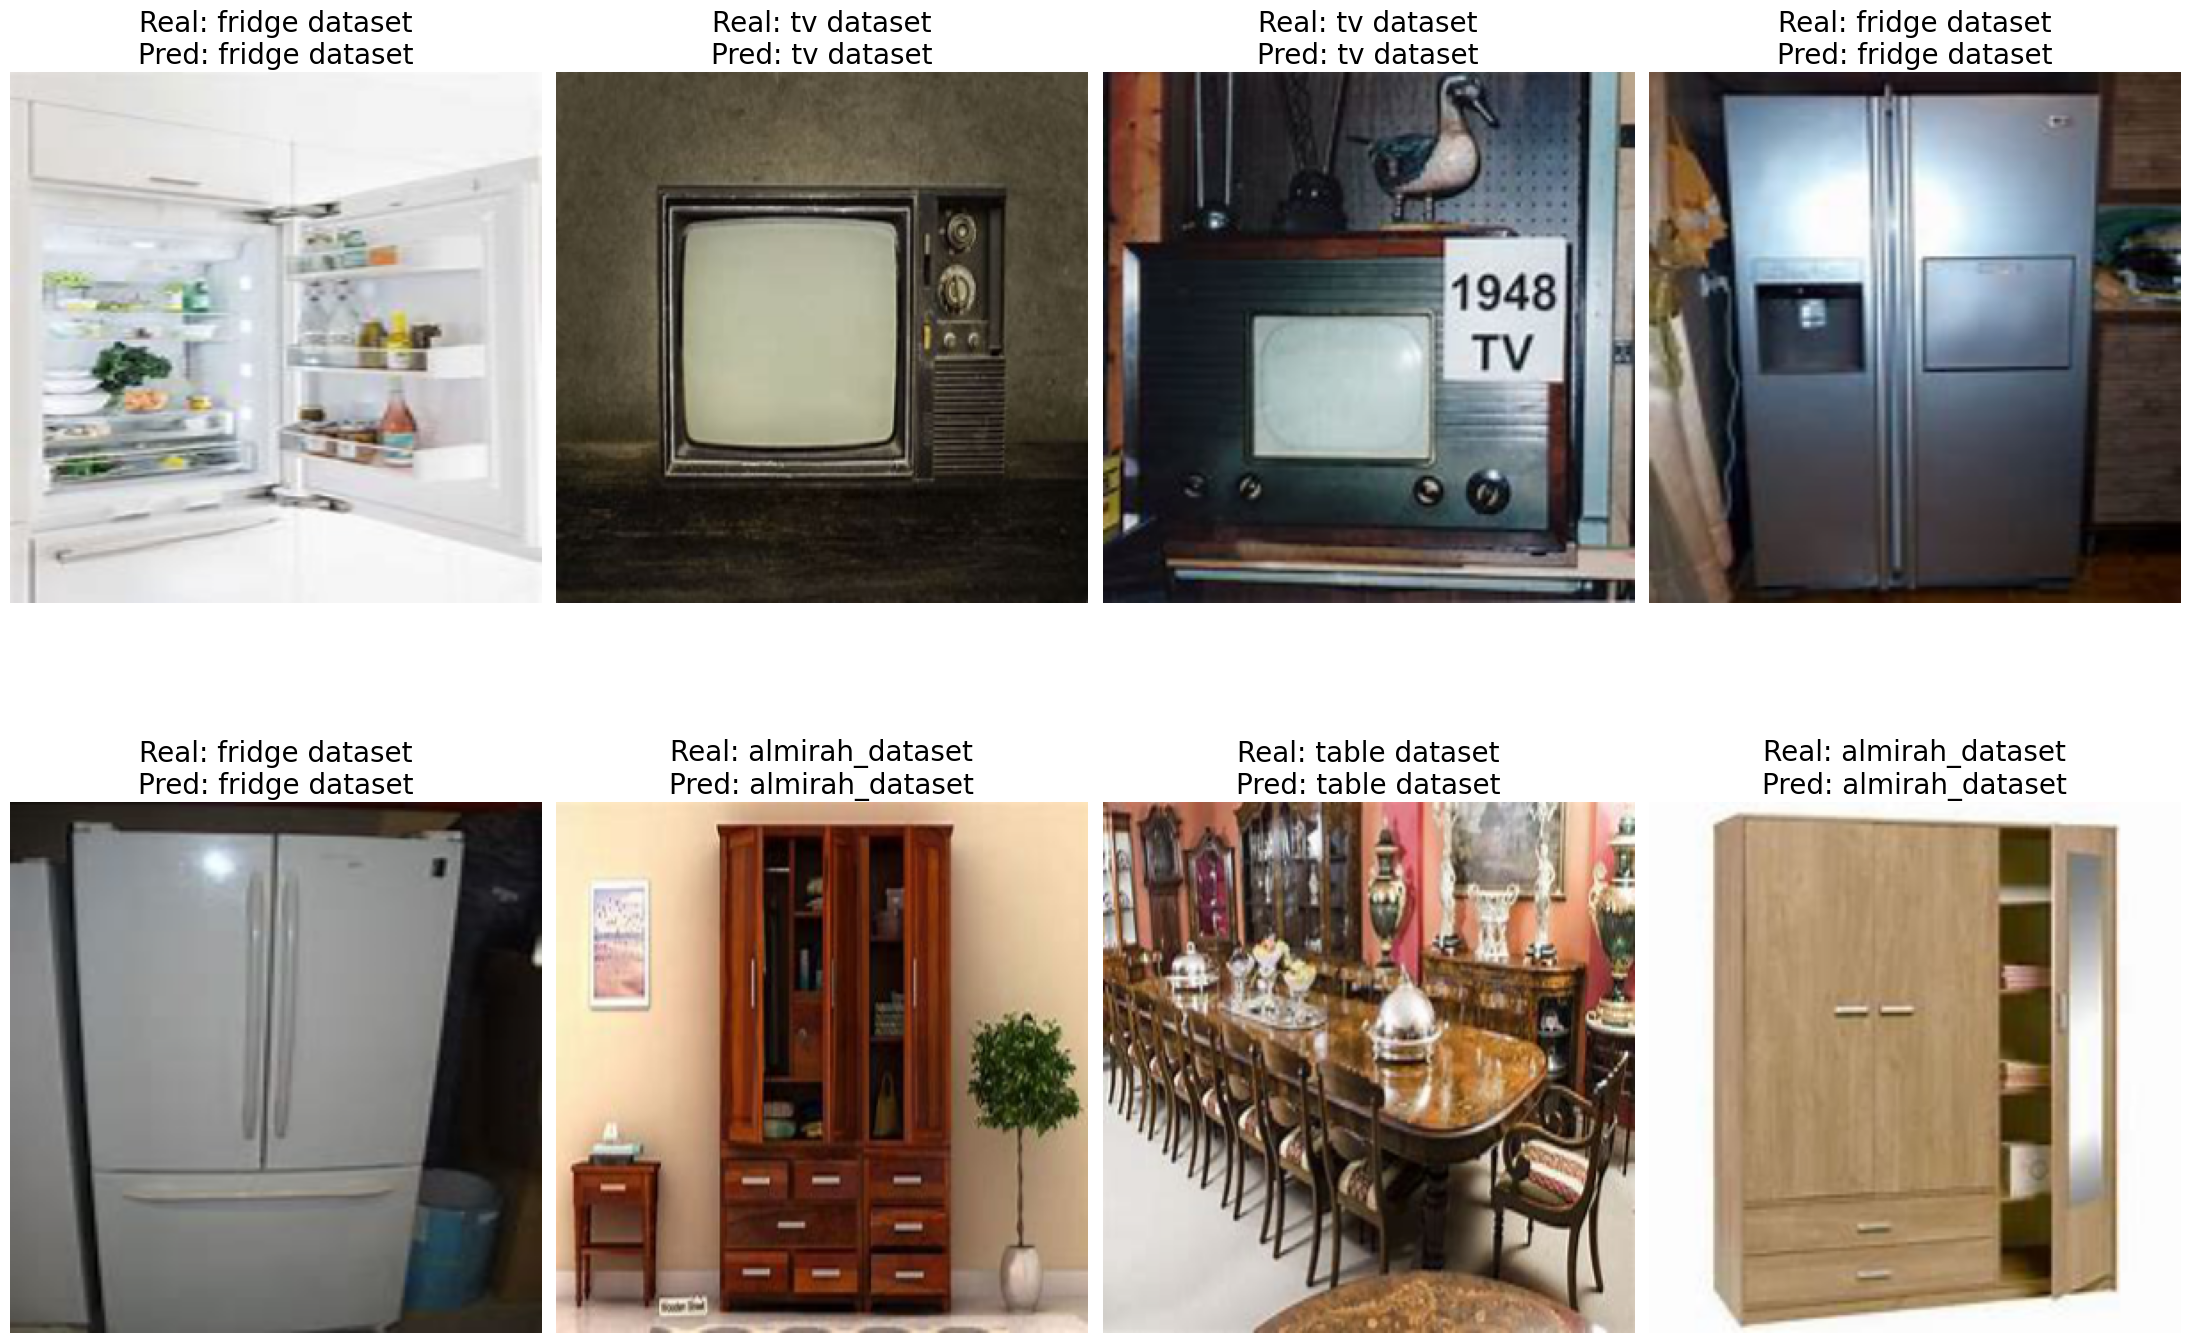

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input

# 클래스 이름 정의
CLASS_NAMES = [
        'almirah_dataset', #0
        'chair_dataset', #1
        'fridge dataset', #2
        'table dataset', #3
        'tv dataset' #4
]

# 이미지 로드 및 전처리 함수
def load_and_preprocess_image(file_path, preprocess=None):
    image = cv2.imread(file_path)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        if preprocess:
            image = preprocess(image)
    else:
        print(f"Error loading image: {file_path}")
        # 오류 발생 시 빈 이미지 또는 대체 이미지 반환
        image = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.uint8)
    return image

# 이미지 크기 설정
IMAGE_SIZE = 299
BATCH_SIZE = 64

# 이미지 시각화 함수 정의
def show_images(images, targets, predictions, nrows=2, ncols=4, fontsize=16):
    fig, axes = plt.subplots(figsize=(22, 16), nrows=nrows, ncols=ncols)
    axes = axes.flatten()  # axes를 1차원 배열로 변환

    for i in range(len(images)):
        ax = axes[i]
        img = images[i]
        ax.imshow(img)
        target = int(targets[i])
        prediction = int(predictions[i])
        ax.set_title(f'Real: {CLASS_NAMES[target]}\nPred: {CLASS_NAMES[prediction]}', fontsize=fontsize)
        ax.axis('off')  # 축 숨기기

    # 사용되지 않는 subplot 숨기기
    for j in range(len(images), nrows * ncols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# 테스트 데이터 제너레이터 생성
test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

test_dataset = Dataset(test_file_paths, 
                        test_targets, 
                        batch_size=BATCH_SIZE,
                        preprocess=xception_preprocess_input)

# 모델 예측 수행
pred_probas = model.predict(test_dataset)
pred_classes = np.argmax(pred_probas, axis=1)

# 원본 이미지 로드
real_test_images = np.array([load_and_preprocess_image(fp) for fp in test_file_paths])

# 테스트 데이터와 예측값 시각화 (제너레이터에서 이미지와 타겟을 가져옴)
show_images(real_test_images[:8], test_targets[:8], pred_classes[:8], fontsize=20)


## 4-2. xception 성능이 높게 나왔지만 예측 확률이 vgg 보다 1개 못맞추는 경향이 있었기 때문에 복잡도를 높이기 위해 layer 층을 1개층 높여 훈련 진행
- 이미지 사이즈를 높였을 때 성능이 높았지만 학습 시간에 효율이 좋지 않기 때문에 이미지 사이즈를 vgg 모델과 동일하게 하여 layer층을 1개층 높여 훈련 진행

In [50]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras import layers

IMAGE_SIZE = 64
BATCH_SIZE = 64

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 20
    
    train_file_paths, train_targets, \
    validation_file_paths, validation_targets, \
    test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=preprocess, 
                        shuffle=True)

    validation_dataset = Dataset(validation_file_paths, 
                            validation_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=preprocess)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])

    # feature extractor layer들을 전부 freeze
    for layer in model.layers[:-5]:
        layer.trainable = False

    model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=FIRST_EPOCHS, 
              validation_data=validation_dataset)

    # 배치 정규화만 freeze 진행
    # for layer in model.layers:
    #     if not isinstance(layer, layers.BatchNormalization):
    #         layer.trainable = True

    # 부분 freeze 진행
    for layer in model.layers[-11:]:
        layer.trainable = True
    
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=SECOND_EPOCHS, 
              validation_data=validation_dataset)
    
    return model, history

In [52]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

aug = A.Compose([
    A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.5)
])

model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'xception', 
          aug,
          xception_preprocess_input)

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 31, 31,    │        864 │ input_layer_9[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 31, 31,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 31, 31,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 29, 29,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 29, 29,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 29, 29,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 29, 29,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 29, 29,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 29, 29,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 29, 29,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 29, 29,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 15, 15,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 15, 15,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        512 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_48 (Add)        │ (None, 15, 15,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 15, 15,    │          0 │ add_48[0][0]    

 Total params: 20,964,185 (79.97 MB)

 Trainable params: 20,909,657 (79.76 MB)

 Non-trainable params: 54,528 (213.00 KB)

Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 46s 294ms/step - acc: 0.5499 - loss: 1.1593 - val_acc: 0.8888 - val_loss: 0.4058
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 46s 308ms/step - acc: 0.7988 - loss: 0.6112 - val_acc: 0.9217 - val_loss: 0.2926
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 47s 314ms/step - acc: 0.8218 - loss: 0.5195 - val_acc: 0.9467 - val_loss: 0.2177
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 46s 303ms/step - acc: 0.8523 - loss: 0.4437 - val_acc: 0.9546 - val_loss: 0.1694
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 47s 310ms/step - acc: 0.8580 - loss: 0.4207 - val_acc: 0.9625 - val_loss: 0.1434
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 48s 319ms/step - acc: 0.8645 - loss: 0.3880 - val_acc: 0.9692 - val_loss: 0.1193
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 46s 305ms/step - acc: 0.8831 - loss: 0.3449 - val_acc: 0.9808 - val_loss: 0.1074
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 46s 303ms/step - acc: 0.8832 - loss: 0.3353 - val_acc: 0.9812 - val_loss: 0.0993
Epoch 9/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 47s

In [53]:
test_dataset = Dataset(test_file_paths, 
                            test_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=xception_preprocess_input)

model.evaluate(test_dataset, batch_size=32)

47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 256ms/step - acc: 1.0000 - loss: 1.0651e-04


[0.00012039825378451496, 1.0]

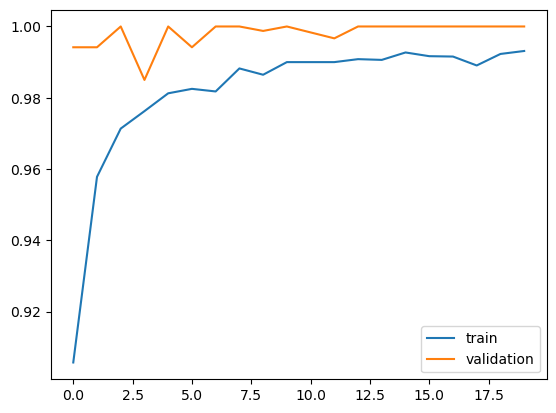

In [54]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()

47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 263ms/step


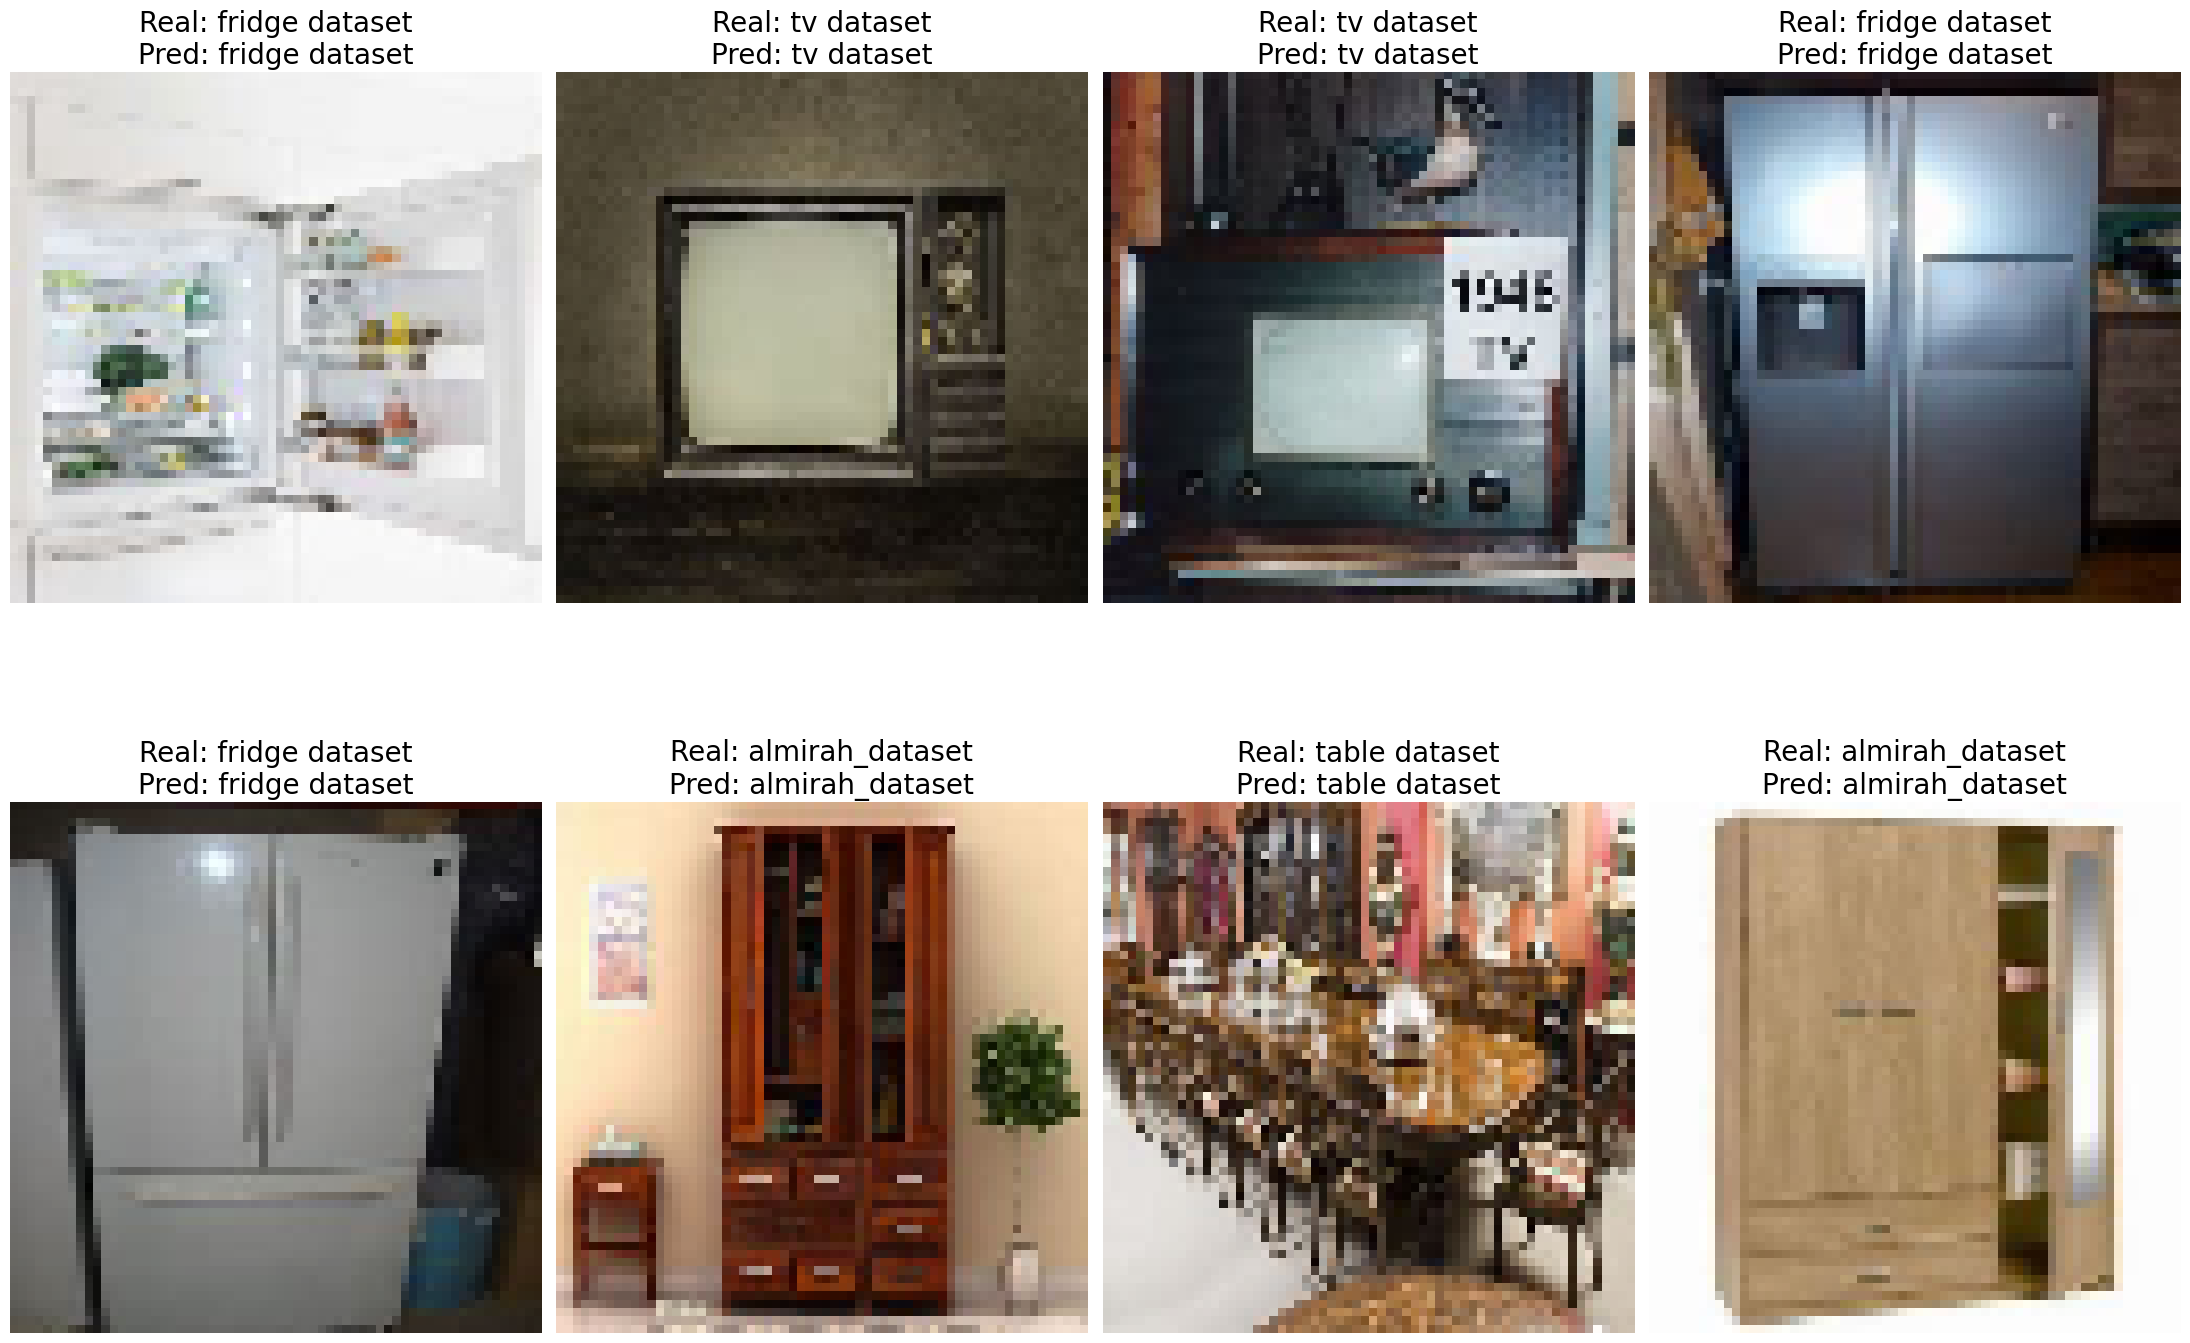

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input

# 클래스 이름 정의
CLASS_NAMES = [
        'almirah_dataset', #0
        'chair_dataset', #1
        'fridge dataset', #2
        'table dataset', #3
        'tv dataset' #4
]

# 이미지 로드 및 전처리 함수
def load_and_preprocess_image(file_path, preprocess=None):
    image = cv2.imread(file_path)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        if preprocess:
            image = preprocess(image)
    else:
        print(f"Error loading image: {file_path}")
        # 오류 발생 시 빈 이미지 또는 대체 이미지 반환
        image = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.uint8)
    return image

# 이미지 크기 설정
IMAGE_SIZE = 64
BATCH_SIZE = 64

# 이미지 시각화 함수 정의
def show_images(images, targets, predictions, nrows=2, ncols=4, fontsize=16):
    fig, axes = plt.subplots(figsize=(22, 16), nrows=nrows, ncols=ncols)
    axes = axes.flatten()  # axes를 1차원 배열로 변환

    for i in range(len(images)):
        ax = axes[i]
        img = images[i]
        ax.imshow(img)
        target = int(targets[i])
        prediction = int(predictions[i])
        ax.set_title(f'Real: {CLASS_NAMES[target]}\nPred: {CLASS_NAMES[prediction]}', fontsize=fontsize)
        ax.axis('off')  # 축 숨기기

    # 사용되지 않는 subplot 숨기기
    for j in range(len(images), nrows * ncols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# 테스트 데이터 제너레이터 생성
test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

test_dataset = Dataset(test_file_paths, 
                        test_targets, 
                        batch_size=BATCH_SIZE,
                        preprocess=xception_preprocess_input)

# 모델 예측 수행
pred_probas = model.predict(test_dataset)
pred_classes = np.argmax(pred_probas, axis=1)

# 원본 이미지 로드
real_test_images = np.array([load_and_preprocess_image(fp) for fp in test_file_paths])

# 테스트 데이터와 예측값 시각화 (제너레이터에서 이미지와 타겟을 가져옴)
show_images(real_test_images[:8], test_targets[:8], pred_classes[:8], fontsize=20)


## 각 검증 수치별 그래프 확인

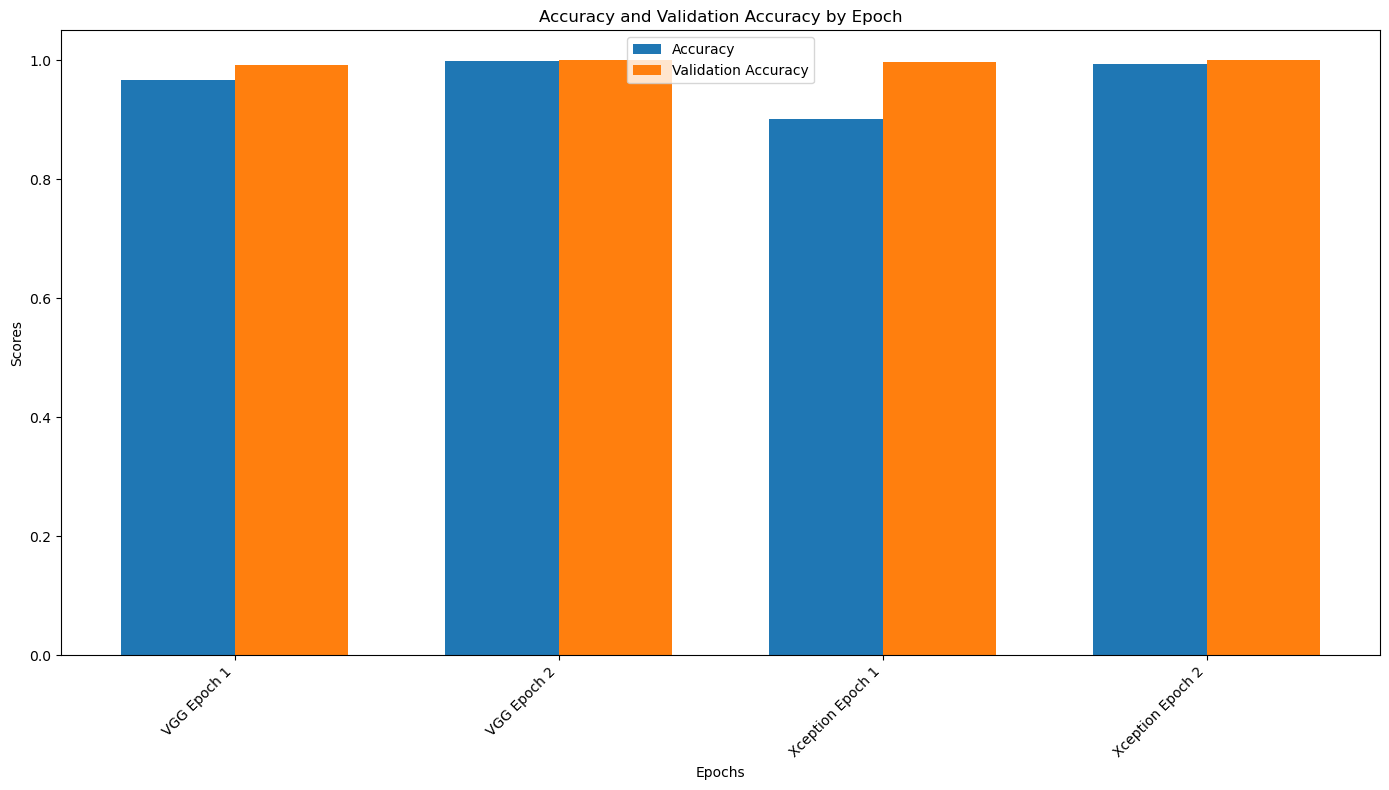

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Data Preparation
labels = [
    'VGG Epoch 1', 'VGG Epoch 2',
    'Xception Epoch 1', 'Xception Epoch 2'
]

acc = [0.9662, 0.9982, 0.9004, 0.9930]

val_acc = [0.9917, 1.0000, 0.9971, 1.0000]

# Plotting the graph
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width/2, acc, width, label='Accuracy')
rects2 = ax.bar(x + width/2, val_acc, width, label='Validation Accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Epochs')
ax.set_ylabel('Scores')
ax.set_title('Accuracy and Validation Accuracy by Epoch')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.legend()

fig.tight_layout()

plt.show()


## 6. 결론
- 모델 선택: VGG16 모델과 Xception 모델을 훈련하였으며, 사전 훈련 모델에서는 VGG 모델에서 유사도가 높은 부분을 확인하였습니다.
- 모델 성능 개선: 초기 훈련부터 분류기 부분만 훈련을 시켰을 때도 높은 성능을 보여줬습니다.
- 학습 속도의 효율을 높이기로 결정하였습니다.
- VGG모델에서는 분류기를 사용했을때도 검증 데이터를 매우 높은 수치로 맞췄으며 xception모델을 훈련시켰을 때는 layer층을 1층 높이거나 이미지 사이즈를 키웠을 떄 vgg 모델과 유사한 수치를 보였습니다.
- vgg모델에서는 400s-> 120s 로 미세조정을 통한 속도의 성능을 높였으며,
- xception모델에서는 70s -> 40s 로 속도의 성능을 높였습니다.
- 이미지 사이즈를 높이지 않고 작은 이미지 사이즈를 훈련을 시켰을 때는 vgg 모델에서 효과를 봤었지만 학습 시간의 효율성을 봤을 때는 xception을 활용하는 것이 더 유용할 것이라고 생각됩니다.

## 7. 느낀점
- 해당 데이터에 대해서는 오히려 유사도가 높은 경우 훈련데이터의 정확도보다 검증데이터 및 테스트 데이터가 수치가 더 높을 수 있음을 확인하였습니다.
- 데이터 증강을 통한 일반화를 통해 훈련을 진행했을 경우 과적합의 내용도 보이지 않고 검증데이터가 높은 예측을 잘 수행하는 모델임을 확인하였고 xception 에 대해서는 여러 차원의 이미지를 확인하다보니 이미지 사이즈거 너무 작은 경우 형태만 바라보고 이미지 사이즈를 처음에 키워서 분석을 할 경우 더 예측을 잘 하는 모습을 보였습니다.
- 따라서 복잡도가 어느정도 나타나는 이미지에 대해서는 xception 모델이 조금 더 유리하다는 점을 확인할 수 있었고 훈련속도 또한 미세 조정을 했을 때 VGG 모델보다 120s -> 40s 로 1/3 정도로 효율을 높인 부분을 확인하였습니다.
- 유사도가 가장 높다고 해서 해당 모델을 사용하는 것이 아닌 미세조정을 통해 layer 층을 조금 높이더라도 더욱 효율적인 모델을 사용해야겠다는 판단이 들었습니다.